# Assessment Overview
***

On the [keras website](https://keras.io/), there is an example of [time-series anomaly detection](https://keras.io/examples/timeseries/timeseries_anomaly_detection/). Re-create this example in a notebook of your own, explaining the concepts.   

Clearly explain each keras function used, referring to the documentation.   

Include an introduction to your notebook, setting the context and describing what the reader can expect as they read down through the notebook.   

Include a conclusion section where you suggest improvements you could make to the analysis in the notebook.

# Introduction
***

Keras is an Application Programming Interface(API) that can be used in Python to build deep learning models. Running on top of the machine learning library TensorFlow, Keras is designed to be a higher level introduction to deep learning, with the goal of fast experimentation. This allows the user to focus more on the ideas and outcomes they wish their models to achieve without needing to focus as much on the underlying mathematics performed by TensorFlow.

The Keras website provides [examples](https://keras.io/examples/) for many deep learning tasks, such as the one that will be looked at in this notebook, ["Timeseries anomaly detection using an Autoencoder"](https://keras.io/examples/timeseries/timeseries_anomaly_detection/). The goal of these examples appears to be to show the user what to do so the user can get started as quickly as possible. However, they provide little detail as to why and how the example code works. This notebook attempts to expand upon the example provided by Keras for Timeseries anomaly detection using an Autoencoder by discussing the purpose of the Keras functions they use and how those functions work, why they make the choices they do when it comes to model design, and suggest aspects of their design that might be improved upon. While most of the code comes from the example provided by Keras, there are some adaptions throughout that come from [here](https://github.com/ianmcloughlin/2223-S1-machine-learn-stats/blob/main/notebooks/05-evaluation.ipynb). 

In [1]:
# Numerical arrays.
import numpy as np

# Spreadsheet-like Data Frames.
import pandas as pd

# Neural networks.
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt

This is the code that imports the packages needed to run this code. Numpy is a package that allows for quick and easy manipulation of numerical arrays. Pandas is used to create data frames, which is used to work with data that is similar to a spreadsheet in excel. Keras is the package which is used for neural networks and deep learning models. Of note is that the example on the Keras website imports keras and tensorflow.keras.layers separately. This does make the code shorter when using layers functions, but with the drawback of it being less clear to anyone looking at the code where the layers functions come from. Instead, this notebook will use the longer code of calling keras.layers for clarity. Finally, matplotlib.pyplot is imported to plot data throughout the notebook.

## Data

***

https://www.kaggle.com/datasets/boltzmannbrain/nab

https://github.com/numenta/NAB

The data used in this example comes from Numenta Anomaly Benchmark(NAB) and can be found from the links above. Their data is used to evaluate algorithms to detect anomalies in streaming data. More specifically, this notebook will use two datasets from NAB. The first dataset is art_daily_small_noise.csv, which is an artificial dataset that has some small amounts of noise and variation in data values, but does not contain any anomalous values. The file contains two columns of data. The first column contains a timestamp of the date and time the measurement was taken, and the second column contains the value measured at that time. Exactly what that value measures is not clear from looking at the data, nor is it important for the purposes of our task to detect anomalies. The second dataset is called art_daily_jumpsup.csv and is similar to the first dataset but with one important difference - somewhere among the data is a series of anomalous data values. The Keras example shows how we can use Keras functions and the dataset with no anomalies to train a model to learn what patterns of data values are considered normal at specific times. The model can then be tested to see if it can show where the anomalies are in the second dataset. 

In [2]:
# Root of URLs.
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'

# Data file without anomaly.
no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'

# Data file with anomaly.
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'

In [3]:
# Check that the url for the no anomaly csv file is concatonated correctly
no_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv'

In [4]:
# Check that the url for the with anomaly csv file is concatonated correctly
with_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv'

The code is hosted on the NAB github page and can be imported to python using the URLs of the CSV files that store the data. It's worth noting that the URLs are raw to get direct access to the CSV files. If we navigate through the repositories to the CSV files, the URL will end in .csv, for example https://github.com/numenta/NAB/blob/master/data/artificialNoAnomaly/art_daily_small_noise.csv, but this URL cannot be used to import the CSV to python as it is actually a HTML link that renders the CSV file. Instead, we can click on the 'Raw' button at the HTML link to get the link that Python can use to import the CSV data. 

In [5]:
# Import the small noise no anomaly csv to a pandas dataframe
df_small_noise = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

Pandas can be used to read in the data from the CSV file into a format that Python can use. The parse_dates argument can be passed as True to ensure that the timestamps are read in correctly as dates and times. The timestamp column is also used as the index for the data frame. 

In [6]:
# Look at the first five entries of the no anomaly data
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [7]:
# View some summary statistics of the no anomaly data
df_small_noise.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


Since the dataset has thousands of values, it's not practical to manualy look at each entry to see if it's been read in correctly. What can be done instead is to look at the first five entries using the .head() Pandas function and use the .describe() Pandas function to get some summary statistics which can provide some useful information. We can compare these to the data held on github and see that by looking at the head, it appears that the values have been rounded when imported to pandas to six decimal places. We can also see that there are 4032 entries, which lines up with the CSV file, which has 4033, but it counts the headings as the first entry whereas Pandas doesn't. We can also visualise the data somewhat with this information. Half of the dataset falls between the minimum value of 18.000964 and the median of 21.608487. There is then a large difference between the median and the 75th percentile value of 75.450282 and the maximum value of 87.976128. This suggest a somewhat stable baseline value of ~20 for most values, and a less stable peak of ~80 for other values. 

In [8]:
# View information about the first entry of the no anomaly data
df_small_noise.iloc[0]

value    18.324919
Name: 2014-04-01 00:00:00, dtype: float64

In [9]:
# View the complete value of the first value imported as pandas seems to have rounded the values to 10 decimal places
df_small_noise.iloc[0]['value']

18.3249185392

In [10]:
# Confirming that the first value has been rounded. It was 18.324918539200002 in the original csv
df_small_noise.iloc[0].values[0]

18.3249185392

It's worth taking a closer look at the first value imported to see how it's been rounded by Pandas and whether that rounding is something which could be of concern for our model and analysis. Using .iloc[0] to get information about the first row in the dataframe shows the same value as when we looked at the head, but if we access only the value from the first row, it shows us that the value has more decimal places than initially appeared, but is still rounded from the original value of 18.324918539200002. This is due to a read_csv argument called float_precision, which is equal to None if it's not explicitly specified by the user. If we explicitly set float_precision='round_trip', then the values will not be rounded.

In [12]:
# Import the small noise no anomaly csv to a pandas dataframe without rounding values
df_small_noise2 = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp", float_precision='round_trip')

# Show that the value has now not been rounded by Pandas
df_small_noise2.iloc[0]['value']

18.324918539200002

Since the original Keras example proceeds with the rounded values this notebook will do the same, but it's worth highlighting that Pandas may round values since there may be other datasets where we would want the original values to be maintained without any rounding. 

In [13]:
# Confirming the shape of the output is what's expected
df_small_noise.shape

(4032, 1)

Checking the shape confirms that we have a one-dimensional set of values (as the timestamp is considered to be an index and not an extra column of data) which contains 4032 data points.

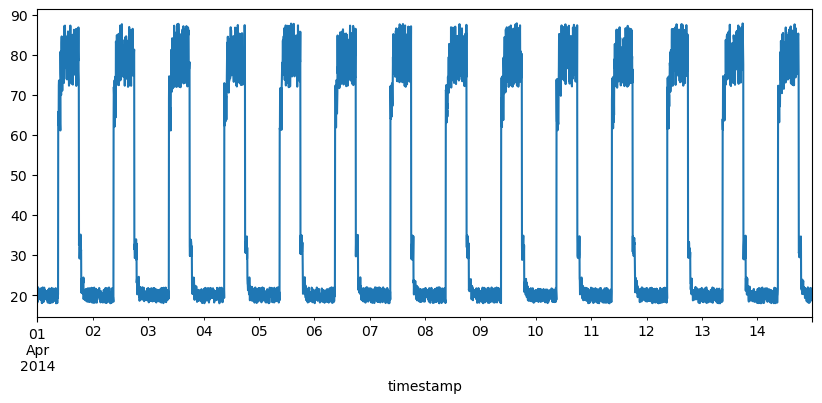

In [13]:
# Specify a size for the plot
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot the no anomaly data frame.
df_small_noise.plot(legend=False, ax=ax);

We can use PyPlot and Pandas to plot the data for us so we can easily visualise its contents. As suggested by the summary statistics, the data appears to fluctuate around a baseline of 20 before it spikes and has a larger fluctuation between ~73 and ~87. This is a pattern that repeats at regular intervals. Indeed, this plot makes it easy to see that there is a pattern to the data. While the values for each cycle are not identical every time, they are similar enough to suggest there is a narrow range of values that can be considered normal.

In [14]:
# Import the daily jumpsup with anomaly csv to a pandas dataframe
df_daily_jumpsup = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

In [15]:
# Look at the first five entries of the with anomaly data
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


In [16]:
# View some summary statistics of the with anomaly data
df_daily_jumpsup.describe()

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


We can use the same process to import the data that we know contains an anomaly using Pandas. The head and description make the dataset look very similar to the no anomaly dataset, except for one major difference. The maximum value for the no anomaly dataset was 87.976128 but the maximum value for the dataset with anomalies is 164.947481 - nearly twice the value. This is enough to increase both the mean and standard deviation by a few points each. 

In [17]:
# View information about the first entry of the with anomaly data
df_daily_jumpsup.iloc[0]['value']

19.761251903

In [18]:
# Confirming the shape of the output is what's expected
df_daily_jumpsup.shape

(4032, 1)

Again we can see that the first value has been rounded, so at least we know that while the values are rounded, it has been done consistently across both datasets. The shape is also what we expect so between that, the head, and the descriptive statistics, we can feel confident that the CSV has been read in correctly. 

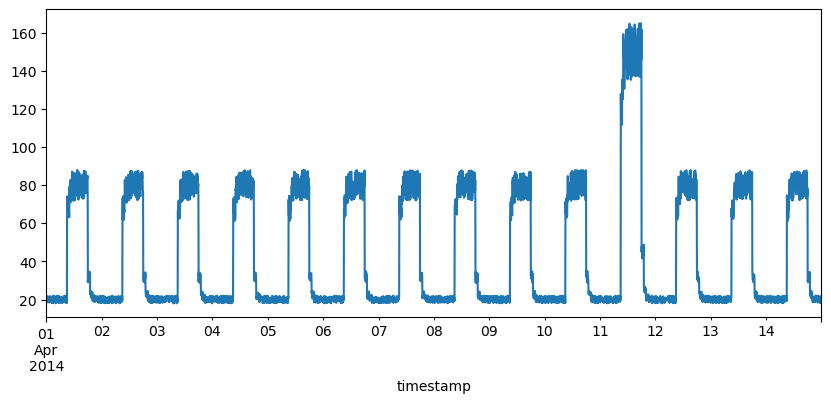

In [19]:
# Specify a size for the plot
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot the with anomaly data frame.
df_daily_jumpsup.plot(legend=False, ax=ax);

Viewing the plot of the with anomaly dataset makes it immediately obvious where the anomaly lies as there are a series of data points that tower far above all the others on the 11th of April. Apart from that, this dataset appears to follow a similar pattern to the no anomaly dataset with a similar baseline, peak, fluctuation, and regularity. 

## Preprocessing

***

In [20]:
# Getting the mean of the values in the no anomaly data
train_mean = df_small_noise.mean()

train_mean

value    42.438353
dtype: float64

In [21]:
# Getting the standard deviation of the values in the no anomaly data
train_std = df_small_noise.std()

train_std

value    28.077122
dtype: float64

https://statisticsbyjim.com/glossary/standardization/

In [22]:
# Standardising the values
df_train_vals = (df_small_noise - train_mean) / train_std

In [23]:
# Look at the first five entries of the standardised no anomaly data
df_train_vals.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


In [24]:
# Add a column to the original no anomaly dataframe with the values of the datapoint minus the mean
df_small_noise['less_mean'] = df_small_noise['value'] - df_small_noise['value'].mean()

# Add a column to the original no anomaly dataframe with standardised values
df_small_noise['div_std'] = df_small_noise['less_mean'] / df_small_noise['value'].std()

# Show the no anomoly dataframe with the two newly added columns
df_small_noise

,value,less_mean,div_std
timestamp,,,
2014-04-01 00:00:00,18.324919,-24.113435,-0.858829
2014-04-01 00:05:00,21.970327,-20.468026,-0.728993
2014-04-01 00:10:00,18.624806,-23.813547,-0.848148
2014-04-01 00:15:00,21.953684,-20.484669,-0.729586
2014-04-01 00:20:00,21.909120,-20.529234,-0.731173
...,...,...,...
2014-04-14 23:35:00,20.211195,-22.227159,-0.791647
2014-04-14 23:40:00,20.531041,-21.907313,-0.780255
2014-04-14 23:45:00,19.032127,-23.406226,-0.833640


In [25]:
# View the mean of the three columns in the no anomaly data 
df_small_noise['value'].mean(), df_small_noise['less_mean'].mean(), df_small_noise['div_std'].mean()

(42.438353335806646, -7.342627387941552e-14, -2.616541242931684e-15)

In [26]:
# View the standard deviation of the three columns in the no anomaly data
df_small_noise['value'].std(), df_small_noise['less_mean'].std(), df_small_noise['div_std'].std()

(28.077122281262515, 28.077122281262508, 1.0000000000000018)

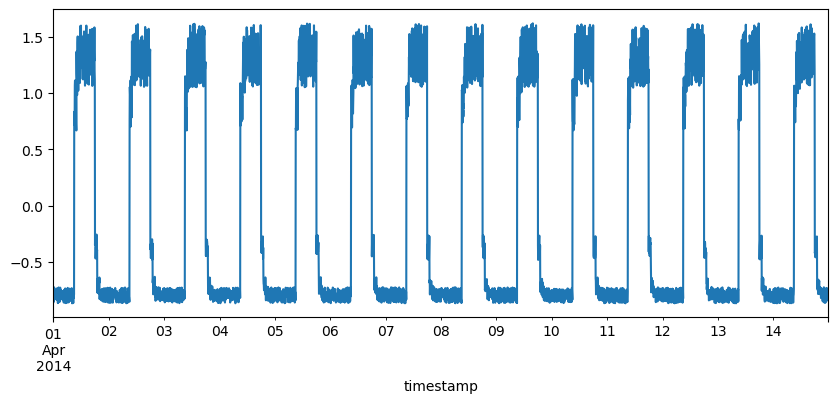

In [27]:
# Specify a size for the plot
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot the standardised no anomaly data frame.
df_train_vals.plot(legend=False, ax=ax);

In [28]:
# Confirming that the shape of the standardised no anomaly data is what we expect
df_train_vals.shape

(4032, 1)

In [29]:
# Specifying the size for the windows
window_size = 288

Window example:

```python
[1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
window_size = 3
[1, 1, 2]
[1, 2, 4]
[2, 4, 5]
[4, 5, 6]
...
```

In [30]:
# Window list example.
L = [1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
# Example window size.
win_size = 3
# Length of L.
len(L)

12

In [31]:
# Number of windows from L.
len(L) - (win_size - 1)

10

In [32]:
# Remove brackets.
len(L) - win_size + 1

10

In [33]:
# Print the windows.
for i in range(len(L) - win_size + 1):
    print(L[i:i + win_size])

[1, 1, 2]
[1, 2, 4]
[2, 4, 5]
[4, 5, 6]
[5, 6, 7]
[6, 7, 1]
[7, 1, 2]
[1, 2, 3]
[2, 3, 4]
[3, 4, 5]


In [34]:
# For accumulating the windows.
wins = []

# Generate the windows
for i in range(len(L) - win_size + 1):
    wins.append(L[i:i + win_size])

wins

[[1, 1, 2],
 [1, 2, 4],
 [2, 4, 5],
 [4, 5, 6],
 [5, 6, 7],
 [6, 7, 1],
 [7, 1, 2],
 [1, 2, 3],
 [2, 3, 4],
 [3, 4, 5]]

In [35]:
# Create a 2D numpy array from wins.
np.stack(wins)

array([[1, 1, 2],
       [1, 2, 4],
       [2, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 1],
       [7, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5]])

In [36]:
# Function to return windowed values of the input data
def windows(vals, N=window_size):
  # Create an empty list to append the windowed data to
  L = []
  # Iterate over the inpuit data for the length of the specified window
  for i in range(len(vals) - N + 1):
    # Append the input data which is the same length as the specified window
    L.append(vals[i:i+N])
  # Stack windows into an array
  return np.stack(L)

In [37]:
# Use the windows function on the standardised no anomaly data
x_train = windows(df_train_vals)

In [38]:
# View the standardised no anomaly data which is now divided into windows
x_train

array([[[-0.85882857],
        [-0.72899302],
        [-0.84814772],
        ...,
        [-0.86453747],
        [-0.81250829],
        [-0.79671155]],

       [[-0.72899302],
        [-0.84814772],
        [-0.72958579],
        ...,
        [-0.81250829],
        [-0.79671155],
        [-0.78767946]],

       [[-0.84814772],
        [-0.72958579],
        [-0.731173  ],
        ...,
        [-0.79671155],
        [-0.78767946],
        [-0.73706287]],

       ...,

       [[-0.8226548 ],
        [-0.86660975],
        [-0.82181363],
        ...,
        [-0.79164661],
        [-0.78025492],
        [-0.83364049]],

       [[-0.86660975],
        [-0.82181363],
        [-0.75595835],
        ...,
        [-0.78025492],
        [-0.83364049],
        [-0.73510213]],

       [[-0.82181363],
        [-0.75595835],
        [-0.74256753],
        ...,
        [-0.83364049],
        [-0.73510213],
        [-0.8460886 ]]])

In [39]:
# Check the first and last entry
x_train[0][0], x_train[-1][-1]

(array([-0.85882857]), array([-0.8460886]))

In [40]:
# Extra detail about the first and last entry
df_train_vals.iloc[0], df_train_vals.iloc[-1]

(value   -0.858829
 Name: 2014-04-01 00:00:00, dtype: float64,
 value   -0.846089
 Name: 2014-04-14 23:55:00, dtype: float64)

In [41]:
# Confirming the shape of the windowed no anomaly data
x_train.shape

(3745, 288, 1)

In [42]:
# Check some of the original standardised no anomaly data to see if they match the windowed data
df_train_vals['value'].values

array([-0.85882857, -0.72899302, -0.84814772, ..., -0.83364049,
       -0.73510213, -0.8460886 ])

In [43]:
# Flatten and view the data points in the first window 
x_train[0].flatten()

array([-0.85882857, -0.72899302, -0.84814772, -0.72958579, -0.731173  ,
       -0.75730984, -0.77645641, -0.7880838 , -0.747012  , -0.829166  ,
       -0.80377285, -0.7821597 , -0.81182078, -0.80949918, -0.82334701,
       -0.79001779, -0.74922405, -0.84169024, -0.73727717, -0.77223023,
       -0.75311352, -0.79116337, -0.75934728, -0.86809294, -0.75381057,
       -0.86468256, -0.74361965, -0.72908121, -0.82850668, -0.84043795,
       -0.76136364, -0.8343536 , -0.74708881, -0.85574949, -0.85245676,
       -0.73090636, -0.77440264, -0.74974936, -0.82419543, -0.77402585,
       -0.78574242, -0.7844733 , -0.77316412, -0.78843253, -0.80927467,
       -0.83109167, -0.76090519, -0.83816509, -0.77176485, -0.83715923,
       -0.78131343, -0.76396862, -0.83924191, -0.86186112, -0.85174179,
       -0.78406773, -0.74938477, -0.86399047, -0.76581026, -0.82177506,
       -0.80222751, -0.73807119, -0.82310669, -0.80410682, -0.86845167,
       -0.85877599, -0.83356075, -0.86643297, -0.78045221, -0.80

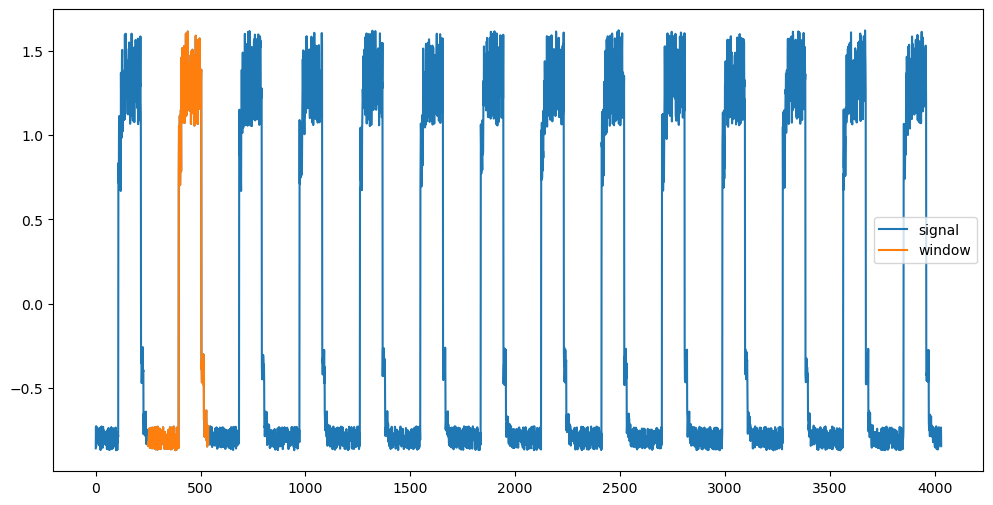

In [44]:
# Select the 250th window
window_no = 250

# Specify a size for the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Get the standardised no anomaly data
y = df_train_vals['value'].values

# Plot the standardised no anomaly data
ax.plot(np.arange(y.shape[0]), y, label='signal')

# Get the values contained in the window number specified earlier
# Flattened to be able to plot them
w = x_train[window_no].flatten()

# Plot the data from the window specified on top of the standardised no anomaly plot 
ax.plot(np.arange(w.shape[0]) + window_no, w, label='window')
ax.legend();

## Neural Network

***

In [45]:
# Confirming the shape of the windowed no anomaly data
x_train.shape

(3745, 288, 1)

In [46]:
# Defining the layers for the model
layers = [
  # Shape of the input
  keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
  # Apply 1d convolutional filters 
  keras.layers.Conv1D(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  # Define the dropout rate to prevent overfitting
  keras.layers.Dropout(rate=0.2),
  # Apply 1d convolutional filters
  keras.layers.Conv1D(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  # Apply transposed 1D convolution/deconvolution
  keras.layers.Conv1DTranspose(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  # Define the dropout rate to prevent overfitting
  keras.layers.Dropout(rate=0.2),
  # Apply transposed 1D convolution/deconvolution
  keras.layers.Conv1DTranspose(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  # Apply transposed 1D convolution/deconvolution
  keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
]

In [47]:
# Add the layers to sequential model
model = keras.Sequential(layers)

In [48]:
# Specify the optimization algorithm to use during training
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [49]:
# Compile the model for training
model.compile(optimizer=optimizer, loss="mse")

In [50]:
# Provide a summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)            2

In [51]:
# Train the model
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 3s 105ms/step - loss: 0.6297 - val_loss: 0.3544
Epoch 2/50
27/27 [==============================] - 2s 76ms/step - loss: 0.1631 - val_loss: 0.0574
Epoch 3/50
27/27 [==============================] - 2s 74ms/step - loss: 0.0613 - val_loss: 0.0404
Epoch 4/50
27/27 [==============================] - 2s 76ms/step - loss: 0.0502 - val_loss: 0.0324
Epoch 5/50
27/27 [==============================] - 2s 77ms/step - loss: 0.0430 - val_loss: 0.0288
Epoch 6/50
27/27 [==============================] - 2s 77ms/step - loss: 0.0367 - val_loss: 0.0268
Epoch 7/50
27/27 [==============================] - 2s 80ms/step - loss: 0.0325 - val_loss: 0.0271
Epoch 8/50
27/27 [==============================] - 2s 80ms/step - loss: 0.0298 - val_loss: 0.0279
Epoch 9/50
27/27 [==============================] - 2s 77ms/step - loss: 0.0275 - val_loss: 0.0264
Epoch 10/50
27/27 [==============================] - 2s 79ms/step - loss: 0.0256 - val_loss: 0.0266
Epoch 11

## Evaluation

***

In [52]:
# Show the loss values for each epoch
history.history["loss"]

[0.6296578645706177,
 0.16307608783245087,
 0.061267364770174026,
 0.05023401975631714,
 0.043044716119766235,
 0.03671189770102501,
 0.032491285353899,
 0.029773809015750885,
 0.027524137869477272,
 0.025646302849054337,
 0.024127289652824402,
 0.022754857316613197,
 0.02146492339670658,
 0.020335868000984192,
 0.019461464136838913,
 0.018641121685504913,
 0.01781972497701645,
 0.017170580103993416,
 0.016464756801724434,
 0.01563587225973606,
 0.01501504983752966,
 0.014344409108161926,
 0.013667319901287556,
 0.012954795733094215,
 0.012254335917532444,
 0.011709745042026043,
 0.011103322729468346,
 0.010613490827381611,
 0.010215149261057377,
 0.009861304424703121,
 0.009525652974843979,
 0.009181683883070946,
 0.008919982239603996,
 0.008631262928247452,
 0.008369230665266514,
 0.008128020912408829,
 0.00794034544378519,
 0.00778412539511919,
 0.007582052145153284,
 0.0074469647370278835,
 0.007301392033696175,
 0.0072143725119531155,
 0.0070960866287350655,
 0.006946776993572712,

In [53]:
# Show the validation loss value for each epoch
history.history["val_loss"]

[0.35435351729393005,
 0.057373467832803726,
 0.04036848619580269,
 0.032360948622226715,
 0.028826070949435234,
 0.026811126619577408,
 0.027120471000671387,
 0.02793029509484768,
 0.02644728124141693,
 0.026643643155694008,
 0.024288412183523178,
 0.02556067332625389,
 0.024217113852500916,
 0.02016441337764263,
 0.021863814443349838,
 0.020544428378343582,
 0.020360078662633896,
 0.017030224204063416,
 0.016475379467010498,
 0.015755323693156242,
 0.015397339127957821,
 0.013475008308887482,
 0.012015772052109241,
 0.011224332265555859,
 0.010580770671367645,
 0.00955228041857481,
 0.0087267542257905,
 0.00847191084176302,
 0.008220885880291462,
 0.007652794010937214,
 0.006930424831807613,
 0.006376473233103752,
 0.006060014013200998,
 0.005872680805623531,
 0.005651193205267191,
 0.005439796485006809,
 0.005139835178852081,
 0.005032030865550041,
 0.004844412207603455,
 0.004742458462715149,
 0.004684532061219215,
 0.0044433618895709515,
 0.00439255777746439,
 0.004295582417398691

Difference between loss and validation loss - https://datascience.stackexchange.com/questions/25267/keras-difference-beetween-val-loss-and-loss-during-training

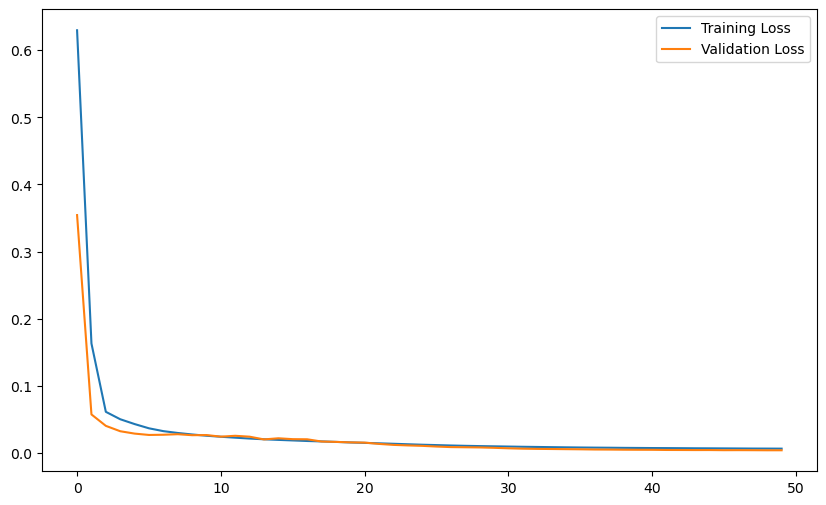

In [54]:
# Specify a size for the plot
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the training loss values
ax.plot(history.history["loss"], label="Training Loss")
# Plot the validation loss values
ax.plot(history.history["val_loss"], label="Validation Loss")
# Add legend to plot
ax.legend();

In [55]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)

In [56]:
# Calculate loss...
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

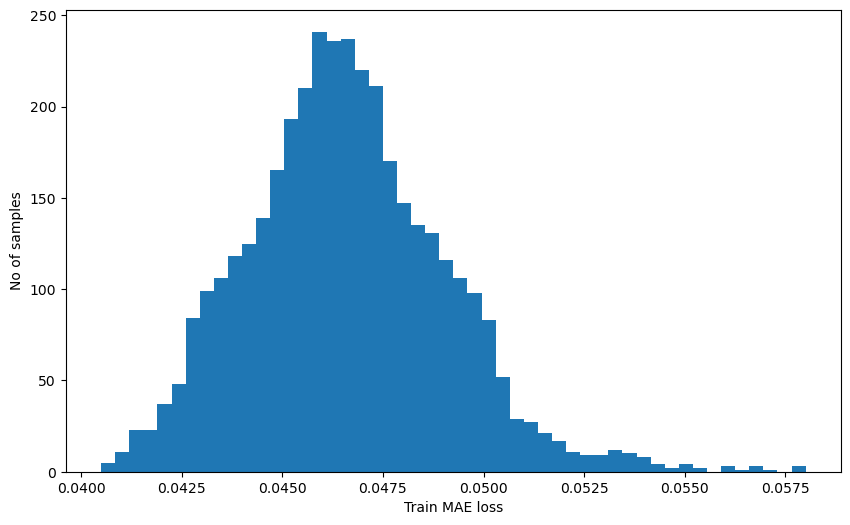

In [57]:
# Specify a size for the plot
fig, ax = plt.subplots(figsize=(10, 6))
# Plot a histogram of MAE values
ax.hist(train_mae_loss, bins=50)
# Label for x-axis
ax.set_xlabel("Train MAE loss")
# Label for y-axis
ax.set_ylabel("No of samples");

In [58]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)

# Show threshold value
threshold

0.05800604828594738

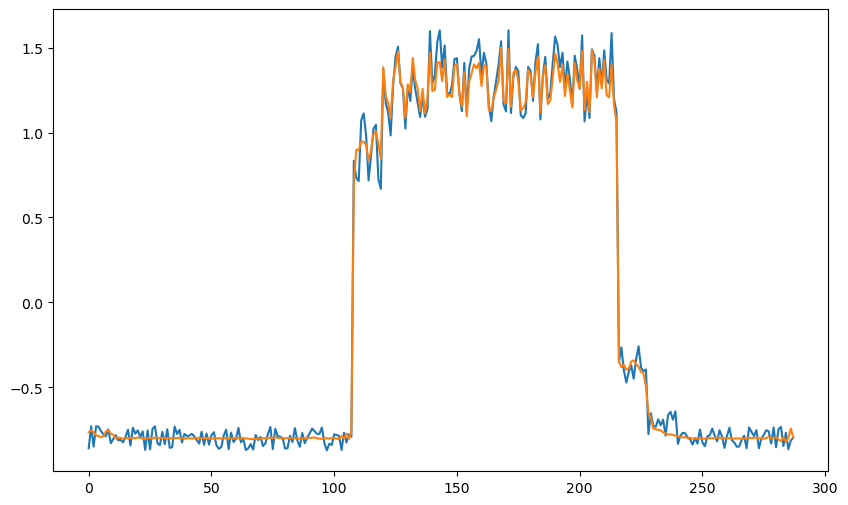

In [59]:
# Specify a size for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the first window of the training data
ax.plot(x_train[0])

# Plot the first window of the predicted data
ax.plot(x_train_pred[0]);

In [60]:
# Standardise the test data which is the with anomaly dataset 
df_test_value = (df_daily_jumpsup - train_mean) / train_std

Why to use the training mean and std to standardise test data - https://stats.stackexchange.com/questions/202287/why-standardization-of-the-testing-set-has-to-be-performed-with-the-mean-and-sd

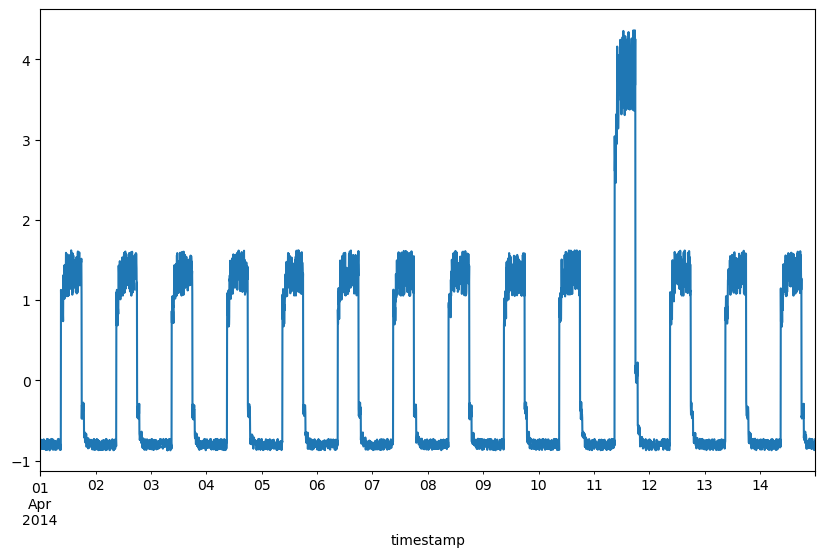

In [61]:
# Specify a size for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the standardised test data
df_test_value.plot(legend=False, ax=ax);

In [62]:
# Create sequences from test values.
x_test = windows(df_test_value.values)

# Show shape of test sequences
x_test.shape

(3745, 288, 1)

In [63]:
# Use the model to reconstruct the test data to calculate MAE loss
x_test_pred = model.predict(x_test)

In [64]:
# Calculate test MAE loss
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

# View test MAE loss
test_mae_loss

array([[0.04711218],
       [0.04649361],
       [0.04603166],
       ...,
       [0.04920471],
       [0.04835057],
       [0.04805788]])

In [65]:
# Reshape test MAE loss to a 1d array
test_mae_loss = test_mae_loss.reshape((-1))

# View reshaped test MAE loss
test_mae_loss

array([0.04711218, 0.04649361, 0.04603166, ..., 0.04920471, 0.04835057,
       0.04805788])

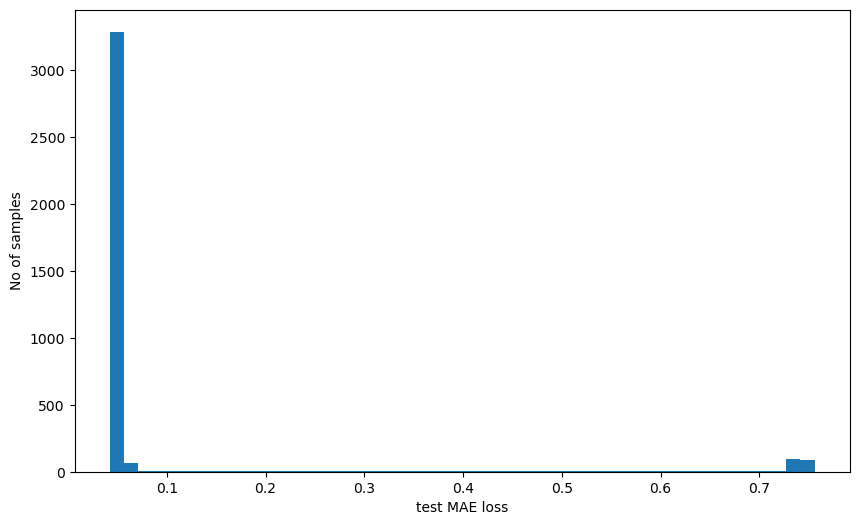

In [66]:
# Specify a size for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot a histogram of the test MAE loss
ax.hist(test_mae_loss, bins=50)

# Set x-axis label
ax.set_xlabel("test MAE loss")

# Set y-axis label
ax.set_ylabel("No of samples");

In [67]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold

# Number of anomalies.
np.sum(anomalies)

424

In [68]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
inds = []

for i in range(window_size - 1, len(df_test_value) - window_size + 1):
    if np.all(anomalies[i - window_size + 1 : i]):
        inds.append(i)

In [69]:
# Get the data from the locations that were detected to be anomalies from the with anomaly data
df_subset = df_daily_jumpsup.iloc[inds]

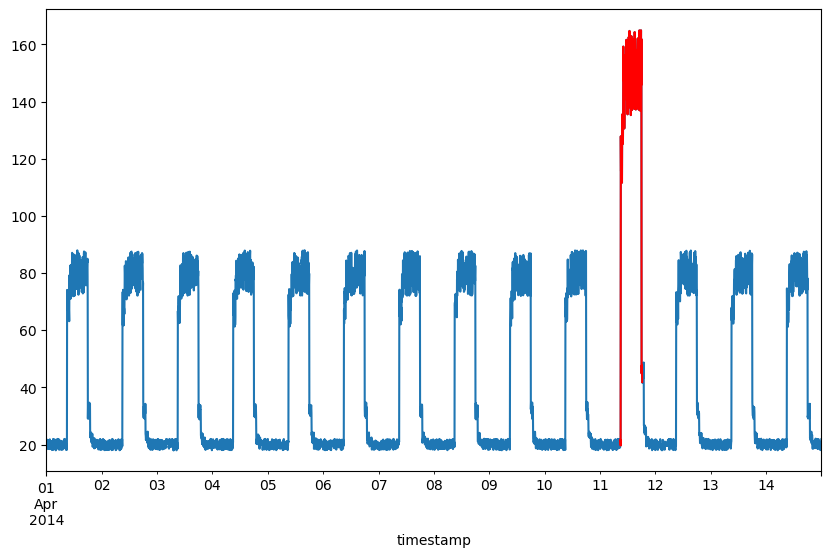

In [70]:
#Specify a size for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the with anomaly data
df_daily_jumpsup.plot(legend=False, ax=ax)

# Plot the data flagged as anomalous by the model
df_subset.plot(legend=False, ax=ax, color="r");

## Conclusion

***

# References
***

https://statisticsbyjim.com/glossary/standardization/

https://datascience.stackexchange.com/questions/25267/keras-difference-beetween-val-loss-and-loss-during-training

https://stats.stackexchange.com/questions/202287/why-standardization-of-the-testing-set-has-to-be-performed-with-the-mean-and-sd